Used different models including linear regression, lasso and ridge, decision tree classifier, random forest and ada boost classifier to train on the orchid classification dataset

In [2]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression as LR
from sklearn.linear_model import Lasso as L1
from sklearn.linear_model import Ridge as L2
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.model_selection import GridSearchCV as GCV
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.ensemble import AdaBoostClassifier as ABC
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [3]:
house_path = 'Data/housing_data/'
gene_path = 'Data/gene_data/'

In [4]:
X_house = pd.read_csv(house_path + 'train_x.csv', header=None)
Y_house = pd.read_csv(house_path + 'train_y.csv', header=None)

In [5]:
X_gene = pd.read_csv(gene_path + 'gene_train_x.csv', header=None)
Y_gene = pd.read_csv(gene_path + 'gene_train_y.csv', header=None)
X_gene_test = pd.read_csv(gene_path + 'gene_test_x.csv', header=None)
Y_gene_test = pd.read_csv(gene_path + 'gene_test_y.csv', header=None)

In [6]:
clfs = [
    LR(), L1(), L2()
]

params = {
    LR.__name__: {}, 
    L1.__name__: {
        'alpha': np.arange(0, 201)
    },
    L2.__name__: {
        'alpha': np.arange(0, 201)
    }
}

In [47]:
results = []
for clf in clfs:
    clf_cv = GCV(clf, params[clf.__class__.__name__], scoring='neg_mean_absolute_error', cv=5, n_jobs=-1, verbose=1)
    clf_cv.fit(X_house, Y_house)
    results.append(clf_cv)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 5 folds for each of 201 candidates, totalling 1005 fits


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   32.7s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   52.2s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 1005 out of 1005 | elapsed:  1.5min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 5 folds for each of 201 candidates, totalling 1005 fits


[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 328 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 828 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 982 out of 1005 | elapsed:    8.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 1005 out of 1005 | elapsed:    8.2s finished


In [58]:
def get_score(grid_cv):
    result = grid_cv.cv_results_
    name = grid_cv.best_estimator_.__class__.__name__
    test_scores = list(-result['mean_test_score'])
    max_index = test_scores.index(np.min(test_scores))
    alpha = result['params'][max_index]['alpha']
    return name, alpha, test_scores[max_index]
for re in results:
    if re.best_estimator_.__class__.__name__ != 'LinearRegression':
        print(get_score(re))
print(results[0].cv_results_['mean_test_score'])

('Lasso', 83, 17292.31497816319)
('Ridge', 44, 17809.90763026434)
[-18053.89726575]


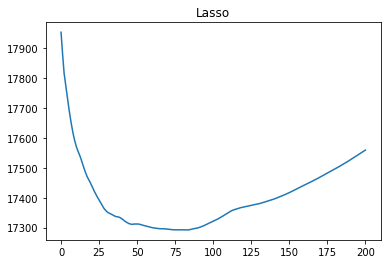

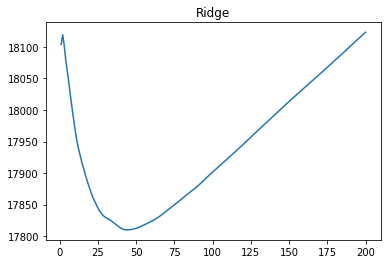

In [67]:
def get_plot_xy(grid_cv):
    result = grid_cv.cv_results_
    name = grid_cv.best_estimator_.__class__.__name__
    test_scores = list(-result['mean_test_score'])
    alphas = [a['alpha'] for a in result['params']]
    if name == 'Ridge':
        alphas = alphas[1:]
        test_scores = test_scores[1:]
    return name, alphas, test_scores

for re in results:
    if re.best_estimator_.__class__.__name__ != 'LinearRegression':
        name, alphas, maes = get_plot_xy(re)
        plt.plot(alphas, maes)
        plt.title(name)
        plt.savefig(name)
        plt.show()

In [36]:
params_rfc = {
    'n_estimators': list(range(1, 151)),
    'max_features': [1 / 3, 1, 'sqrt'],
    'names': ['p / 3', 'p', 'sqrt(p)']
}

In [37]:
rfc_results = {}
for i in range(3):
    f = params_rfc['max_features'][i]
    name = params_rfc['names'][i]
    rfc_results[name] = []
    for e in params_rfc['n_estimators']:
        fitted = RFC(e, max_features=f)
        fitted.fit(X_gene, Y_gene[0].values)
        y_pred = fitted.predict(X_gene_test)
        rfc_results[name].append(accuracy_score(Y_gene_test[0].values, y_pred))

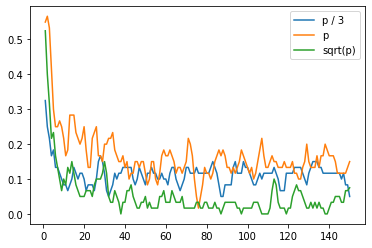

In [41]:
for k, v in rfc_results.items():
    v = list(map(lambda x: 1 - x, v))
    values = []
    for i in range(len(v)):
        value = [v[i]]
        if i > 0:
            value.append(v[i - 1])
        if i + 1 < len(v):
            value.append(v[i + 1])
        values.append(np.mean(value))
    plt.plot(params_rfc['n_estimators'], values, label=k)

plt.legend()
plt.savefig('trees.png')
plt.show()

In [42]:
params_abc = {
    'n_estimators': list(range(1, 151)),
    'max_depth': [1, 2, 3],
}
abc_results = {}
for i in range(3):
    d = params_abc['max_depth'][i]
    name = 'd: {}'.format(d)
    abc_results[name] = []
    for e in params_rfc['n_estimators']:
        fitted_abc = ABC(DTC(max_depth=d), n_estimators=e, learning_rate=0.1)
        fitted_abc.fit(X_gene, Y_gene[0].values)
        y_pred = fitted_abc.predict(X_gene_test)
        abc_results[name].append(accuracy_score(Y_gene_test[0].values, y_pred))

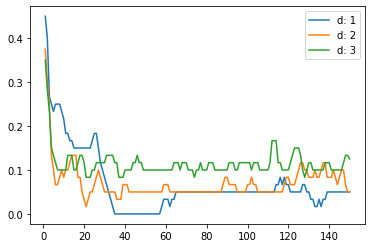

In [43]:
for k, v in abc_results.items():
    v = list(map(lambda x: 1 - x, v))
    values = []
    for i in range(len(v)):
        value = [v[i]]
        if i > 0:
            value.append(v[i - 1])
        if i + 1 < len(v):
            value.append(v[i + 1])
        values.append(np.mean(value))
    plt.plot(params_abc['n_estimators'], values, label=k)

plt.legend()
plt.savefig('abc.png')
plt.show()

In [30]:
params_cls = {
    DTC: {
        'max_depth': list(range(1, 6)),
        'max_features': [1, 1/3, 'sqrt', 'log2']
    },
    ABC: {
        'base_estimator': [DTC()],
        'base_estimator__max_depth': list(range(1, 6)),
        'base_estimator__max_features': [1, 1/3, 'sqrt', 'log2'],
        'n_estimators': list(range(5, 201, 10)),
        'learning_rate': list(np.arange(0.1, 1, 0.1))
    },
    RFC: {
        'max_depth': list(range(1, 6)),
        'max_features': [1, 1/3, 'sqrt', 'log2'],
        'n_estimators': list(range(5, 101, 5))
    },
}

In [33]:
cls_gcvs = {}
for k, v in params_cls.items():
    cls_gcv = GCV(k(), v, scoring='accuracy', cv=5, verbose=1, n_jobs=-1)
    cls_gcv.fit(X_gene, Y_gene[0].values)
    cls_gcvs[k] = cls_gcv


Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done  77 out of 100 | elapsed:    5.4s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.4s finished
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 5 folds for each of 3600 candidates, totalling 18000 fits


[Parallel(n_jobs=-1)]: Done  36 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 412 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 662 tasks      | elapsed:   13.3s
[Parallel(n_jobs=-1)]: Done 1012 tasks      | elapsed:   21.6s
[Parallel(n_jobs=-1)]: Done 1462 tasks      | elapsed:   32.7s
[Parallel(n_jobs=-1)]: Done 2012 tasks      | elapsed:   43.5s
[Parallel(n_jobs=-1)]: Done 2662 tasks      | elapsed:   53.3s
[Parallel(n_jobs=-1)]: Done 3794 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 5494 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 7394 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 15196 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 18000 out of 18000 | elapsed:  2.9min finished
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change num

Fitting 5 folds for each of 400 candidates, totalling 2000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1144 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:   11.9s finished
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [34]:
for k, v in cls_gcvs.items():
    print(k.__name__, 1 - accuracy_score(Y_gene_test[0].values, v.best_estimator_.predict(X_gene_test)))


DecisionTreeClassifier 0.65
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
                       max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')
AdaBoostClassifier 0.9
AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(class_weight=None,
                                                         criterion='gini',
                                                         max_depth=1,
                                                         max_features=1,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                 